In [36]:
from network import *
import numpy as np 
from scipy.sparse import csr_matrix
from scipy.stats import moment
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt("connections.csv", delimiter=",")
N = int(np.max(data)) + 1
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
A = A + A.T
A = 1*(A > 0)

In [3]:
#getting the degrees of the matrix
kmin = 15
degrees = get_degrees(A)

#getting the pdf of the nodes degrees
uniques, pdf = get_neighbours_pdf(degrees)

#getting the cumulative distribution function
cumpdf = ccdf(pdf)

#estimating the parameters to be used in the power law
gamma, c = estimate_power_law(degrees, kmin)
C = c*cumpdf[np.where(uniques == kmin)]
print("gamma = ", gamma)
print("Average degree = ", np.mean(degrees))
print("Statistical power = ", moment(degrees, moment = 2))
print("Third moment = ", moment(degrees, moment = 3))


gamma =  2.4505058418961614
Average degree =  12.287339971550498
Statistical power =  [394.47]
Third moment =  [41720.79]


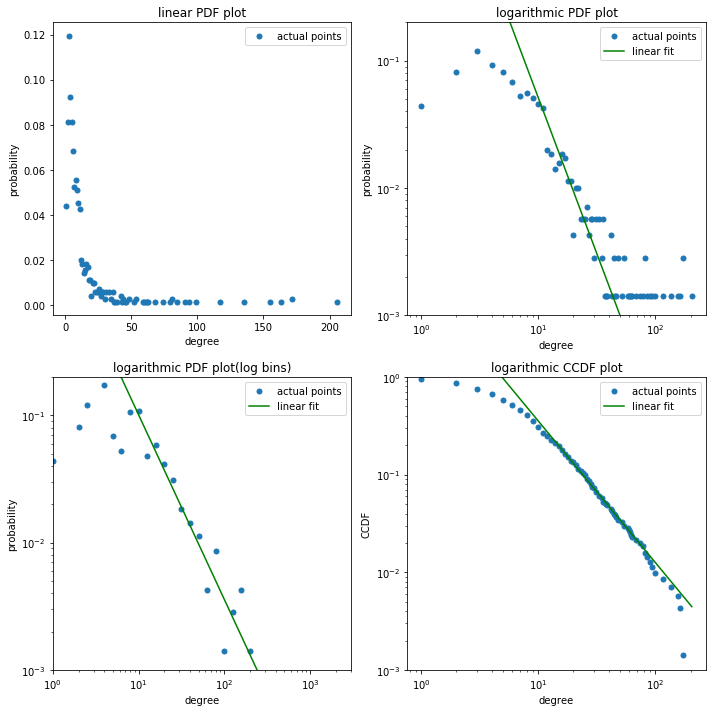

In [4]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

#plotting the pdf
axs[0, 0].set_title("linear PDF plot")
axs[0, 0].plot(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 0].set(xlabel='degree', ylabel='probability')
axs[0, 0].legend(["actual points"])

#plotting the pdf and the linear fit
axs[0, 1].set_title("logarithmic PDF plot")
axs[0, 1].set_ylim(1e-5, 1)
axs[0, 1].loglog(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 1].loglog(np.arange(1, np.max(uniques)), C * (np.arange(1, np.max(uniques)) ** -gamma), c="green")
axs[0, 1].set(xlabel='degree', ylabel='probability')
axs[0, 1].set_ylim(0.001, 0.2)
axs[0, 1].legend(["actual points", "linear fit"])

#plotting the linear binning pdf
axs[1, 0].set_title("logarithmic PDF plot(log bins)")
axs[1, 0].set_xlim(1, 3*10e2)
axs[1, 0].set_ylim(1e-4, 1)
x, y = log_binning_pdf(0.1, degrees)
axs[1, 0].loglog(x, y, marker='o', linestyle='None', ms = 5)
axs[1, 0].loglog(x, C / (gamma - 1) * x ** (1 - gamma) * (1 - (x[1] / x[0]) ** (1 - gamma)), c="green")
axs[1, 0].set(xlabel='degree', ylabel='probability')
axs[1, 0].set_ylim(0.001, 0.2)
axs[1, 0].legend(["actual points", "linear fit"])


#plotting the ccdf and the corresponding linear fit
axs[1, 1].set_title("logarithmic CCDF plot")
axs[1, 1].set_ylim((1e-5, 1))
axs[1, 1].loglog(uniques, ccdf(pdf), marker='o', linestyle='None', ms = 5)
axs[1, 1].loglog(np.arange(1, np.max(uniques)), C * np.arange(1, np.max(uniques))**(1-gamma)/(gamma-1), c="green")
axs[1, 1].set(xlabel='degree', ylabel='CCDF')
axs[1, 1].set_ylim(0.001, 1)
axs[1, 1].legend(["actual points", "linear fit"])

#used to prevent label overlapping
fig.tight_layout()

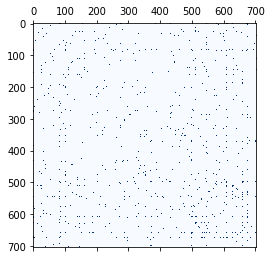

In [5]:
plt.matshow(A.toarray(), cmap="Blues")

In [6]:
characters_id = []
with open("nodes.csv", "r") as fp:
    for line in fp:
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [7]:
indexes = np.argsort(degrees, axis = 0)
for i in indexes[-1:-4:-1, 0]:
    print(characters_id[i])

Tyrion Lannister
Jaime Lannister
Arya Stark


In [8]:
print(N)
A = clean_network(A)
print(A.shape)

703
(703, 703)


max distance =  4.0
average distance =  2.6952904321325373


Text(0.5, 1.0, 'Number of characters that need n hops to reach another character')

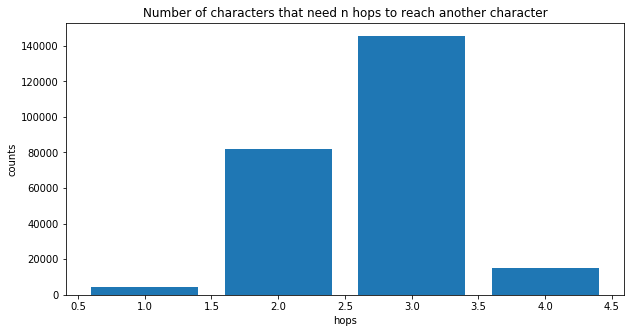

In [9]:
distances, counts = get_distance_distribution(A)
print("max distance = ", distances[-1])
print("average distance = ", np.sum(distances * counts)/np.sum(counts))
plt.figure(figsize=(10, 5))
plt.bar(distances, counts)
plt.xlabel("hops")
plt.ylabel("counts")
plt.title("Number of characters that need n hops to reach another character")

(array([ 32.,   6.,   4.,   8.,  13.,  15.,  22.,  33.,  28.,  41.,  39.,
         47.,  36.,  54.,  33.,  16.,  40.,  16.,  23., 197.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

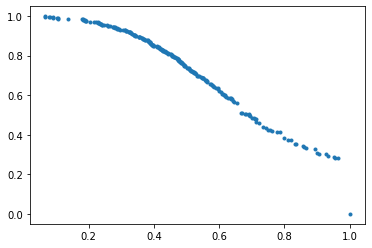

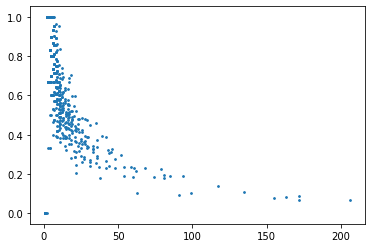

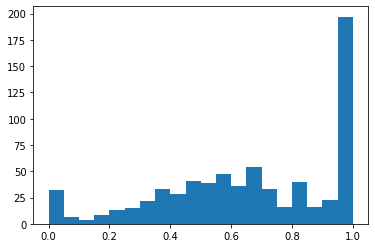

In [10]:
x, y = get_clustering_distribution(A)
plt.plot(x, ccdf(y), marker=".", linestyle = "None")
plt.figure()
clustering = get_clustering_coefficients(A)
plt.scatter(degrees, clustering, s = 3)
plt.figure()
plt.hist(clustering, bins=20)

In [11]:
print(np.mean(clustering), np.log(N)**2/N)
#print(clustering[:, np.newaxis]*)
print(np.sum(clustering[:, np.newaxis]*degrees)/np.sum(degrees))

0.6645814091600907 0.06112760167711178
0.4379779370269687


-0.22841945768210126


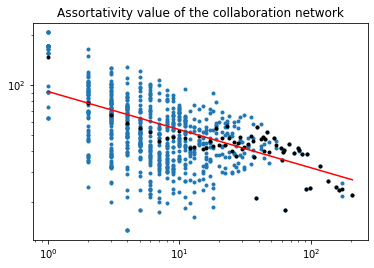

In [12]:
p, unique, knn, temp_knn = get_assortativity_value(A)
degrees = remove_zeros(get_degrees(A))

plt.title("Assortativity value of the collaboration network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
print(p[0])
plt.show()

In [13]:
nodes = [[]]
i = 0
with open("connections_for_temp.csv", "r") as fp:
    for line in fp:
        if line == "end\n":
            i += 1
            nodes.append([])
        else:
            nodes[i].append([int(i) for i in line.replace("\n","").split(',')])            

In [14]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

temporal_A = sp.sparse.csr_matrix((N,N))
temporal_distributions = get_temporal_distribution(temporal_A, nodes)

In [15]:
def parse_distribution(char_dist):
    char_dist_without_duplicates = set(char_dist)
    char_dist_sorted = list(char_dist_without_duplicates)
    char_dist_sorted.sort()
    return np.array(char_dist_sorted)

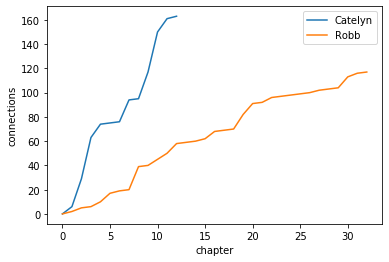

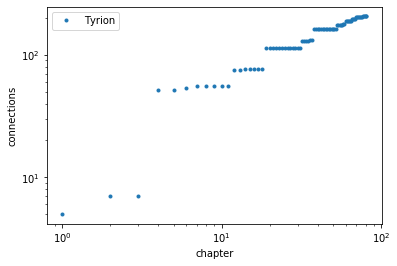

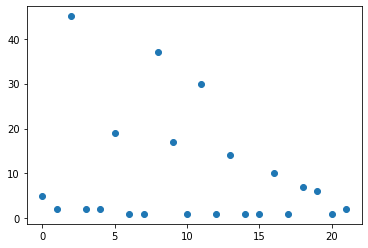

In [79]:
catelyn = temporal_distributions[:, characters_id.index("Catelyn Stark") ,0]
robb = temporal_distributions[:, characters_id.index("Robb Stark") ,0]
plt.plot(parse_distribution(catelyn))
plt.plot(parse_distribution(robb))
plt.xlabel("chapter")
plt.ylabel("connections")
plt.legend(["Catelyn", "Robb"])
plt.figure()
tyrion = temporal_distributions[:, characters_id.index("Tyrion Lannister") ,0]
plt.loglog(tyrion, marker = '.', linestyle="None")
plt.xlabel("chapter")
plt.ylabel("connections")
plt.legend(["Tyrion"])
diffs = np.diff(parse_distribution(tyrion))
meaningful_diffs = diffs[diffs > 7]
unmeaningful_diffs = diffs[diffs < 8]
plt.figure()
plt.scatter(np.arange(len(diffs)), diffs)

0.08766193286074482
1.0825172886989347
['Jon Snow', 'Sam Tarly', 'Walder Frey', 'Donnel Hill', 'Mance Raydar', 'Aemon Targaryen', 'Chett', 'Grenn', 'Craster', 'Edd Tollett', 'Qhorin Halfhand', 'Dywen', 'Thoren Smallwood', 'Harma Dogshead', 'Clydas', 'Bannen', 'Small Paul', 'Ottyn Wythers', 'Benjen Stark', 'Karl', 'Blane', 'Walder Rivers', 'Lark Sisterman', 'Yoren', 'Bernarr', 'Softfoot', 'Ollo Lophand', 'Tumberjon', 'Jarman Buckwell', 'Mallador Locke', 'Kedge Whiteye', 'Maslyn', 'Bessa', 'Gergen', 'Hookface', 'Yaya', 'Iggo', 'Pia', 'Alebelly', 'Eroeh', 'Helly', 'Erreg', 'Polly', 'Septon Murmison', 'Lenn', 'Massey', 'Jogos Nhai', 'Maester Harmune', 'Karlon Stark', 'Greenapple', 'Raymar Royce', 'Quenn', 'Maester Gormon', 'Rhaego', 'Symeon Star-Eyes', 'Carellen', 'Botley', 'Doh Weg', 'Squishlips', 'Spicers', 'Lann', 'Jate', 'Ser Harlan Grandison', 'Lothston']


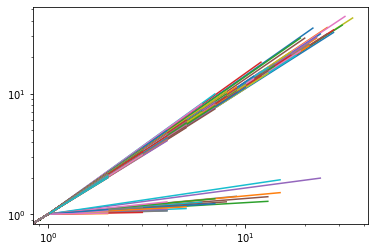

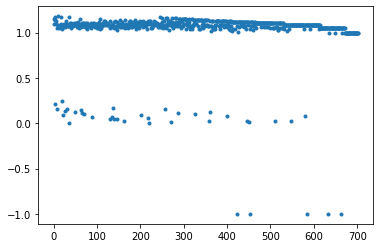

In [83]:
sorted_indexes = np.argsort(degrees)
sorted_indexes = sorted_indexes[::-1]
epsilon = 1e-6
coeffs = []
m = 703
for i in range(m):
    character = parse_distribution(temporal_distributions[:, sorted_indexes[i], 0])
    x = np.arange(len(character))
    if len(x) > 1: 
        p = sp.polyfit(np.log(x + epsilon), np.log(character + epsilon), 1)
        coeffs.append(p[0])
        plt.loglog(x, x ** p[0])
    else: coeffs.append(-1)
plt.figure()
plt.plot(coeffs,marker = '.', linestyle = "None")
coeffs = np.array(coeffs)
min_id = sorted_indexes[(coeffs > 0) & (coeffs < 1)]
print(np.mean(coeffs[(coeffs > 0) & (coeffs < 0.5)]))
print(np.mean(coeffs[coeffs > 0.5]))
print([characters_id[ind] for ind in min_id])

Text(0, 0.5, 'fitness/degree')

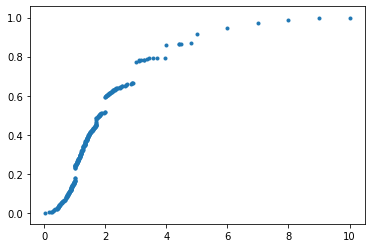

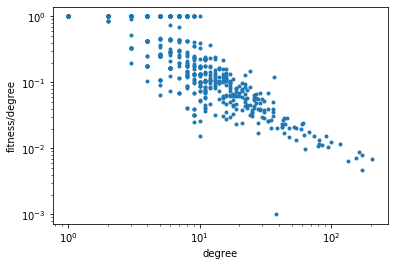

In [28]:
fitnesses = np.zeros(temporal_distributions.shape[1])
for i in range(temporal_distributions.shape[1]):
    y = parse_distribution(temporal_distributions[:, i, 0])
    x = np.arange(1, len(y) + 1)
    x = x[y > 0]
    y = y[y > 0]
    if len(y) > 1:
        p = np.polyfit(np.log(x), np.log(y), 1)
        fitnesses[i] = p[0]
    else:
        fitnesses[i] = y
unique, pdf = get_neighbours_pdf(fitnesses)
plt.scatter(unique, 1-ccdf(pdf), marker='.', linestyle = "None")
plt.figure()
plt.loglog(degrees, fitnesses/degrees, linestyle = "None", marker = '.')
plt.xlabel("degree")
plt.ylabel("fitness/degree")

alpha = 2.3439153514383224 with 2.0183609808587635% of error
beta = 1.0993959097558843 +- 2.552040055360206 % of error


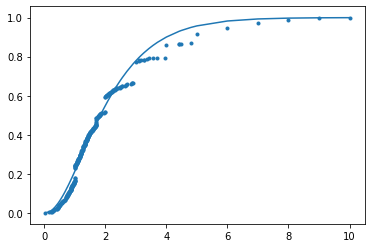

In [18]:
from scipy.special import gammainc
from scipy.optimize import curve_fit

def f(x, alpha, beta):
    return gammainc(alpha, beta*x)


p, cov = curve_fit(f, unique, 1-ccdf(pdf))
plt.scatter(unique, 1-ccdf(pdf), marker='.', linestyle = "None")
plt.plot(unique, f(unique, p[0], p[1]))
print(f"alpha = {p[0]} with {np.sqrt(cov[0,0])/p[0]*100}% of error")
print(f"beta = {p[1]} +- {np.sqrt(cov[1,1])/p[1]*100}% of error")

In [19]:
np.log(np.log(N))

1.8802825614712542

0.004073816960047088


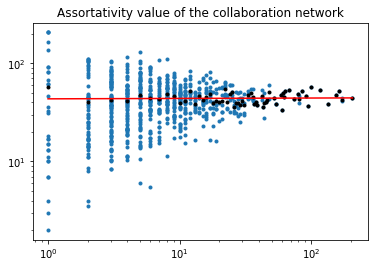

In [20]:
B = random_rewiring(A)
p, unique, knn, temp_knn = get_assortativity_value(B)
degrees = remove_zeros(get_degrees(B))

plt.title("Assortativity value of the collaboration network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
print(p[0])
plt.show()

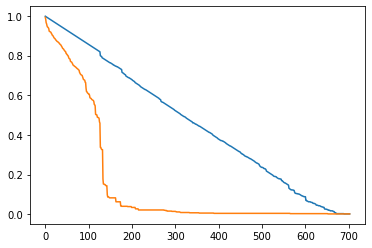

In [21]:
random_removal, attack_removal = check_robustness(A)
plt.plot(np.array(random_removal)/N)
plt.plot(np.array(attack_removal)/N)